<a href="https://colab.research.google.com/github/WilliamMoraesUFCSPA/CI_Saude/blob/main/CNN_Espondilolistese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importação de bibliotecas

In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras as ke
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
import seaborn as sns
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.applications import VGG16


from scipy.spatial.distance import pdist, squareform
import sklearn.metrics as skm

%config Completer.use_jedi = False

import warnings
warnings.simplefilter("ignore")

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Data augmentation (Não rodar novamente, já está salvo na pasta)

In [ ]:
## Diretório onde estão suas imagens no Google Drive
#base_dir = './drive/MyDrive/Mestrado/DatasetEspondilolistese/224/'

# Configuração para o aumento de dados
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Função para carregar imagens
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        if img is not None:
            images.append(np.array(img))
    return images
# Carregar as imagens
class_0_images = load_images_from_folder(os.path.join(base_dir, 'normal'))
class_1_images = load_images_from_folder(os.path.join(base_dir, 'spondylolisthesis'))
# Converter listas para arrays numpy
class_0_images = np.array(class_0_images)
class_1_images = np.array(class_1_images)
# Função para salvar imagens aumentadas
def save_augmented_images(images, save_dir, prefix='aug'):
    i = 0
    for batch in datagen.flow(images, batch_size=1, save_to_dir=save_dir, save_prefix=prefix, save_format='jpeg'):
        i += 1
        if i > len(images):
            break
# Salvar imagens aumentadas no mesmo diretório do Google Drive
save_augmented_images(class_0_images, os.path.join(base_dir, 'normal'), prefix='aug_normal')
save_augmented_images(class_1_images, os.path.join(base_dir, 'spondylolisthesis'), prefix='aug_spondylolisthesis')


Extração dos dados:

In [ ]:
data =  tf.keras.utils.image_dataset_from_directory('./drive/MyDrive/Mestrado/DatasetEspondilolistese/224/',
                                                    batch_size = 302,
                                                    label_mode = 'binary',
                                                    color_mode = 'grayscale',
                                                    image_size = (224, 224))

Found 302 files belonging to 2 classes.


Organização em arrays:

In [ ]:
class_names = data.class_names
X=[]
Y_str=[]

for images, labels in data.take(1): #imagens do batch
  for i in range(0,302):
    X.append(images[i].numpy().astype("uint8"))
    Y_str.append(class_names[labels[i].numpy().astype("uint8")[0]])

X=np.array(X)
if X.shape[-1] == 1:
  X = np.repeat(X, 3, axis=-1)
Y=np.array(Y_str)
Y[np.where(Y=='normal')[0]]=0
Y[np.where(Y=='spondylolisthesis')[0]]=1
Y=Y.astype(int)

Split dos dados:

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.2, random_state=42)

print('treino:',np.shape(X_train))
print('teste:',np.shape(X_test))
print('validacao:',np.shape(X_val))

treino: (241, 224, 224, 3)
teste: (48, 224, 224, 3)
validacao: (13, 224, 224, 3)


Transfer Learning com a última camada falsa para personalizar

In [ ]:
tlearning = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

58889256/58889256 [==============================] - 0s 0us/step


Criação e ajuste do modelo

In [ ]:

model = ke.Sequential()
model.add(tlearning)
model.add(ke.layers.Flatten())
model.add(ke.layers.Dense(128, activation='relu'))  # Camada densa intermediária
model.add(ke.layers.Dropout(0.5))  # Dropout para evitar overfitting
model.add(ke.layers.Dense(1, activation='sigmoid'))  # Camada de saída para classificação binária


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17926209 (68.38 MB)
Trainable params: 17926209 (68.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compilação

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

Treinamento

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("tlearning.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,Y_train,validation_data=(X_val, Y_val), epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
8/8 [==============================] - ETA: 0s - loss: 35.0305 - accuracy: 0.4896  
Epoch 1: val_accuracy improved from -inf to 0.61538, saving model to tlearning.h5
8/8 [==============================] - 496s 61s/step - loss: 35.0305 - accuracy: 0.4896 - val_loss: 0.7044 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 2/12
8/8 [==============================] - ETA: 0s - loss: 1.2476 - accuracy: 0.5394  
Epoch 2: val_accuracy did not improve from 0.61538
8/8 [==============================] - 476s 59s/step - loss: 1.2476 - accuracy: 0.5394 - val_loss: 0.7195 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 3/12
8/8 [==============================] - ETA: 0s - loss: 0.6992 - accuracy: 0.4772  
Epoch 3: val_accuracy did not improve from 0.61538

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
8/8 [==============================] - 486s 59s/step - loss: 0.6992 - accuracy: 0.4772 - val_loss: 0.6496 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 4/12
8/8 [=============

Métricas:

In [ ]:
# Avaliar o modelo usando o conjunto de dados de teste
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)



2/2 [==============================] - 27s 10s/step - loss: 0.3180 - accuracy: 0.8958
Test Loss: 0.31799569725990295
Test Accuracy: 0.8958333134651184


2/2 [==============================] - 26s 8s/step
Confusion Matrix:
 [[18  3]
 [ 2 25]]
Accuracy: 0.8958333333333334
Recall (Sensitivity): 0.9259259259259259
Precision: 0.8928571428571429
F1-Score: 0.9090909090909091
Area Under the ROC Curve (AUC): 0.9435626102292768


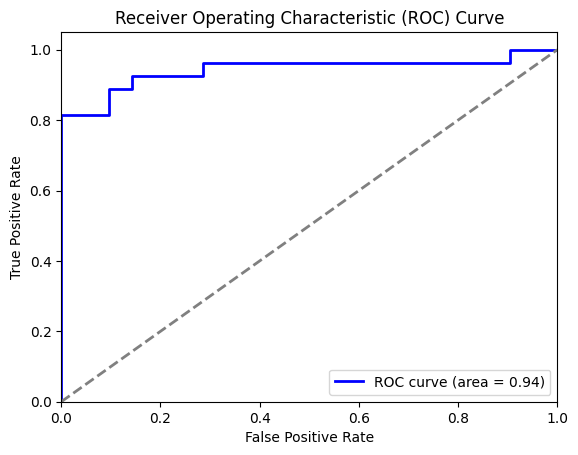

In [ ]:
# Fazer previsões no conjunto de dados de teste
Y_pred = model.predict(X_test)
y_pred = np.where(Y_pred > 0.5, 1, 0).flatten()  # Converte as previsões para rótulos binários

# Calcular as métricas
cm = confusion_matrix(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
auc = roc_auc_score(Y_test, Y_pred)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)

# Exibir as métricas
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Recall (Sensitivity):", recall)
print("Precision:", precision)
print("F1-Score:", f1)
print("Area Under the ROC Curve (AUC):", auc)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


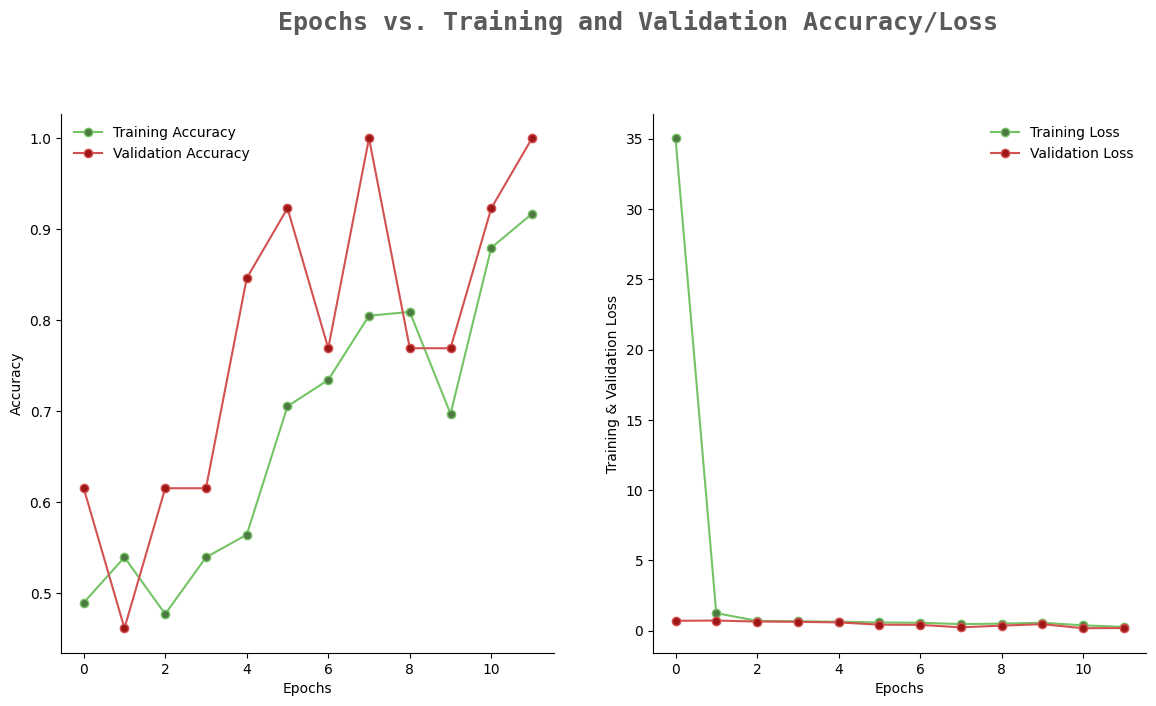

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

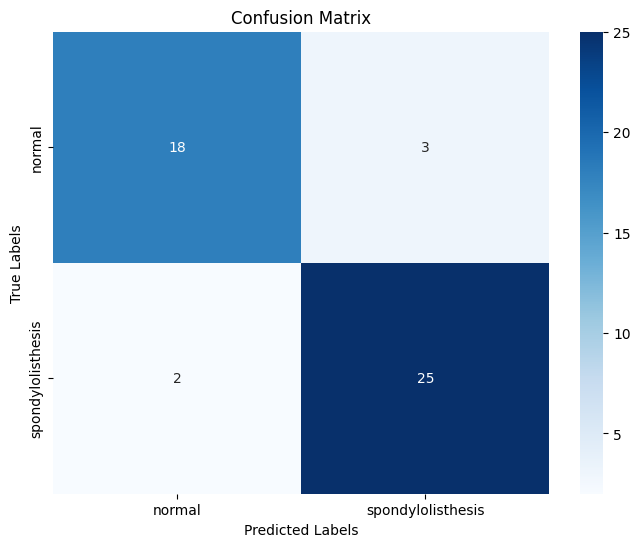

In [ ]:
# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
